In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import glob
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import gaussian_kde

In [4]:
plt.rcParams['figure.figsize'] = (12,10)
plt.style.use('bmh')

## Data pre-processing

In [5]:
#netcdf path
nc_pace_path = '../../hydropt_4_sent3/data/interim/D20200125_125223_PACE_FF0014/*.nc'
nc_olci_path = '../../hydropt_4_sent3/data/interim/D20190813_141238_OLCI_SUNTHETA_ALL/*.nc'

In [7]:
ds = xr.open_mfdataset(nc_pace_path, combine='by_coords')

In [8]:
# subset dataset for just above (Ed) and below (IOPs) sea-surface parameter values
ds = ds.isel(geom_depth=0, geom_depth_air=0, suntheta=0)

In [9]:
# calculate rrs
ds['rrs'] = ds.RADMa/ds.Ed

In [10]:
# subset for NADIR viewing angles
ds_nadir = ds.isel(phi=0, fmu=9)

In [11]:
# select total absorption, total backscatter coefficients and Rrs
var = ['acoef', 'bbcoef', 'rrs']
ds_nadir = ds_nadir[var]

In [12]:
ds_df = ds_nadir.to_dataframe()

In [17]:
ds_df.reset_index(inplace=True)
ds_df.set_index('wavelength', inplace=True)

In [18]:
wbands = ds_df.index.get_level_values('wavelength').unique()

### Sun zenith angle 60 degrees
Load Hydrolight data for OLCI bands at SZA 60 degrees. Validate IOCCG and CCRR on OLCI bands.

In [19]:
# select all files with SZA at 60 deg.: files 6000 - 6999
nc_olci = glob.glob(nc_olci_path)
nc_olci.sort()
nc_olci_sza_60 = nc_olci[6000:7000]

In [20]:
ds_olci = xr.open_mfdataset(nc_olci_sza_60, combine='by_coords')

In [21]:
# subset dataset for just above (Ed) and below (IOPs) sea-surface parameter values
ds_olci = ds_olci.isel(geom_depth=0, geom_depth_air=0, suntheta=0)

In [22]:
# calculate rrs
ds_olci['rrs'] = ds_olci.RADMa/ds_olci.Ed

In [23]:
# subset for NADIR viewing angles
ds_olci_nadir = ds_olci.isel(phi=0, fmu=9)

In [24]:
ds_olci_nadir = ds_olci_nadir[var]

In [25]:
df_olci = ds_olci_nadir.to_dataframe()

In [26]:
df_olci.reset_index(inplace=True)

## IOCCG dataset validation

In [38]:
# load IOCCG IOP-AOPs
ioccg = pd.read_csv('./data/ioccg_rrs_iop_sza_60.csv', index_col='wavelength')

In [39]:
def filter_iop_bounds(x):
    # define lookup table
    hydropt_lut = df_olci.set_index('wavelength')
    # get wavelength
    wl = x.name
    # filter
    mask = ((x.a < hydropt_lut.loc[wl].acoef.max()) &
            (x.bb < hydropt_lut.loc[wl].bbcoef.max()))
    
    return x[mask]

In [40]:
model = make_pipeline(PolynomialFeatures(), linear_model.LinearRegression())

In [41]:
def predict_rrs(x):
    '''predict Rrs using polynomial'''
    # define lookup table
    hydropt_lut = df_olci.set_index('wavelength')
    # get wavelength
    wl = x.name
    X_ioccg = np.log(x[['a','bb']])
    X_hydropt = np.log(hydropt_lut.loc[wl][['acoef','bbcoef']])
    Y_hydropt = np.log(hydropt_lut.loc[wl]['rrs'])
    model.set_params(polynomialfeatures__degree=4)
    rrs_hat = model\
                .fit(X_hydropt, Y_hydropt)\
                .predict(X_ioccg)
    
    return np.exp(rrs_hat)

In [42]:
s = ioccg.groupby('wavelength')\
            .apply(filter_iop_bounds)

In [43]:
s = s.groupby('wavelength')\
     .apply(predict_rrs)

In [44]:
x = ioccg.groupby('wavelength')\
        .apply(filter_iop_bounds)

In [45]:
def mean_bias(x, y):
    return np.sum(y-x)/len(x)

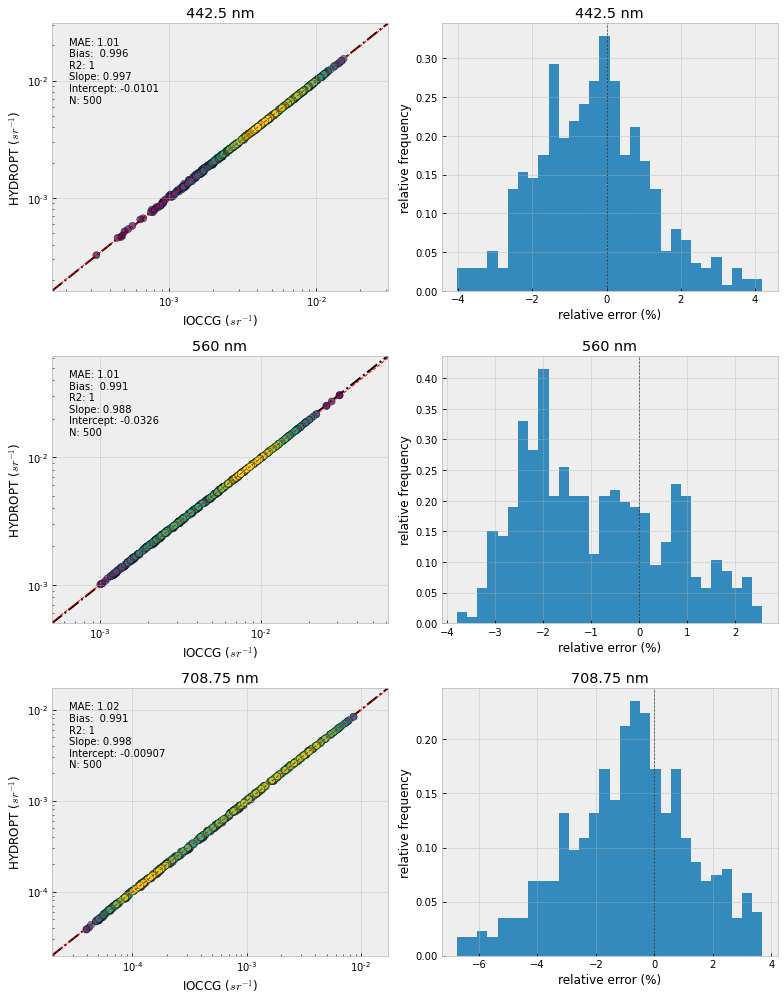

In [55]:
fig, ax = plt.subplots(3,2, figsize=(11,14))
#ax = ax.flatten()
#cols = np.log10(ioccg.set_index('wavelength').loc[400]['a_nw'])
olci = [442.50,560, 708.75]
#olci = [400,560]

for (axs, wl) in zip(ax, olci):
    
    X = x.loc[wl]['Rrs'].values
    Y = s.loc[wl]
    #cols = np.log10(x.loc[wl]['bb_dm'].values)
    X_log, Y_log = np.log10(X).reshape(-1,1), np.log10(Y).reshape(-1,1)
    # calculate scatter point densities
    xy_log = np.vstack([np.log10(X),np.log10(Y)])
    Z = gaussian_kde(xy_log)(xy_log)
    # Sort the points by density, so that the densest points are plotted last
    idx = Z.argsort()
    X, Y, Z = X[idx], Y[idx], Z[idx]
    # determine min and max of axes
    ax_min, ax_max = [np.min(X)*.5, np.max(X)*2]
    # calculate regression stats
    lm = linear_model.LinearRegression().fit(X_log, Y_log)
    # regression line
    x_log_range = np.logspace(np.log10(ax_min), np.log10(ax_max))
    lm_line = np.power(10, lm.coef_[0][0]*np.log10(x_log_range)+lm.intercept_[0])
    # plot scatter
    axs[0].plot(x_log_range,  lm_line, color='red', linewidth=1, linestyle='--')
        
#     cax = axs[0].scatter(X, Y, vmin=-2, vmax=-1, c=Z,
#                       edgecolor='black', linewidth=.5, alpha=.7, s=50, zorder=5)

    axs[0].scatter(X, Y, alpha=.7, c=Z, s=50, edgecolor='black')
    
    axs[0].plot([ax_min,ax_max],[ax_min,ax_max], c='black', linestyle='-.', zorder=0)
    # stats
    mae = np.power(10, mean_absolute_error(X_log, Y_log))
    mb = np.power(10, mean_bias(X_log, Y_log))
    r2 = r2_score(X_log,Y_log)
    slope = lm.coef_[0][0]
    intercept = lm.intercept_[0]
    
    # stats as string
    stat_str = 'MAE: {0:.3g}\nBias: {1: .3g}\nR2: {2:.3g}\nSlope: {3:.3g}\nIntercept: {4:.3g}\nN: {5}'\
            .format(mae,
                    mb,
                    r2,
                    slope,
                    intercept,
                    len(Y))
    
    axs[0].annotate(stat_str, xy=(.05, .95), xycoords='axes fraction', ha='left', va='top')
    
    axs[0].loglog()
    axs[0].set_xlim(ax_min, ax_max)
    axs[0].set_ylim(ax_min, ax_max)
    axs[0].set_xlabel('IOCCG ($sr^{-1}$)')
    axs[0].set_ylabel('HYDROPT ($sr^{-1}$)')
    axs[0].set_title(str(wl) + ' nm')
    #axs[0].grid(which='both')
    
    #histogram
    r_error = 100*(Y-X)/X
    axs[1].hist(r_error, bins=30, density=True)
    axs[1].set_xlabel('relative error (%)')
    axs[1].set_ylabel('relative frequency')
    axs[1].set_title(str(wl) + ' nm')
    axs[1].axvline(0, linestyle='--', linewidth=.7, color='black', alpha=.7)
#fig.colorbar(cax)
plt.tight_layout()

In [47]:
x

spectrum      a_ph       a_g      a_dm         a  \
wavelength wavelength                                                     
442.50     442.50             1  0.005551  0.002414  0.001876  0.016908   
           442.50             2  0.005538  0.007969  0.000561  0.021136   
           442.50             3  0.005458  0.005967  0.000731  0.019224   
           442.50             4  0.005490  0.008258  0.001014  0.021829   
           442.50             5  0.005516  0.003710  0.000804  0.017098   
...                         ...       ...       ...       ...       ...   
708.75     708.75           496  0.010266  0.013222  0.006578  0.831694   
           708.75           497  0.041222  0.048142  0.030595  0.921579   
           708.75           498  0.014673  0.043320  0.007986  0.867605   
           708.75           499  0.009333  0.013813  0.040137  0.864909   
           708.75           500  0.041222  0.007603  0.007157  0.857611   

                          bb_ph     bb_dm        bb       Rrs  
wavelength wavelength                                          
442.50     442.50      0.000238  0.001721  0.004357  0.012008  
           442.50      0.000389  0.000881  0.003669  0.008037  
           442.50      0.000449  0.001160  0.004007  0.009675  
           442.50      0.000819  0.002243  0.005460  0.012003  
           442.50      0.000368  0.001058  0.003824  0.010323  
...                         ...       ...       ...       ...  
708.75     708.75      0.041036  0.077258  0.118644  0.007510  
           708.75      0.034037  0.077860  0.112246  0.006233  
           708.75      0.049568  0.009102  0.059020  0.003320  
           708.75      0.028684  0.099816  0.128850  0.007846  
           708.75      0.015366  0.091492  0.107211  0.006379  

[1500 rows x 9 columns]